Authors: Łukasz Reinke <s15037@pjwstk.edu.pl>

Problem: Train AI to play space invader game

Followed by: github user @deepanshut041

# install os dependencies to display env

In [26]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


# Import python dependencies

In [27]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import math

%matplotlib inline

# start virtual display

In [28]:
from pyvirtualdisplay import Display
Display().start()


#import ai classes

In [29]:
import sys
from agent import A2CAgent
from models import ActorCnn, CriticCnn
from stack_frame import preprocess_frame, stack_frame

# create environment

In [30]:
!pip install "gym[atari,accept-rom-license]==0.25.2" "ale-py==0.10.1"
%pip install gym[atari]

env = gym.make('ALE/SpaceInvaders-v5', render_mode="human")
env.seed(0)

  Using cached gym-0.25.2.tar.gz (734 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ale_py-0.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
INFO: pip is looking at multiple versions of gym[accept-rom-license,atari] to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install ale-py==0.10.1 and gym[accept-rom-license,atari]==0.25.2 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested ale-py==0.10.1
    gym[accept-rom-license,atari] 0.25.2 depends on ale-py~=0.7.5; extra == "atari"

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/depend

(2968811710, 3677149159)

# set accelerator

In [31]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


# view Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


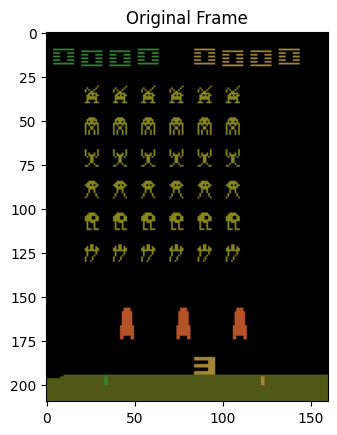

In [32]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
observation, _ = env.reset()  # Pobierz tylko pierwszą wartość z krotki
plt.imshow(observation)
plt.title('Original Frame')
plt.show()

### execute the code cell below to play with a random policy.

In [33]:
import gym

def random_play():
    env = gym.make("Pong-v4", render_mode="human")  # Ustawienie poprawnego trybu renderowania
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)  # Nowe wersje gym zwracają 5 wartości
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break

random_play()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Your Score at end of game is:  -19.0




```
# Sformatowano jako kod
```

# preprocessing frame

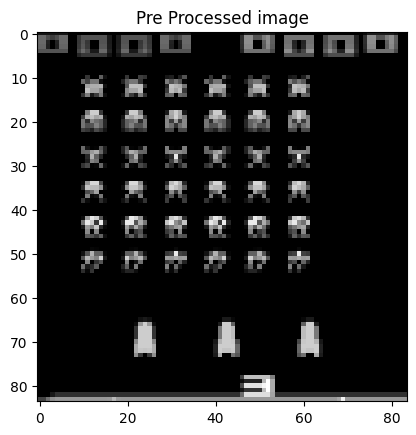

In [34]:
obs, _ = env.reset()  # Pobierz tylko pierwszą wartość (obraz)
plt.figure()
plt.imshow(preprocess_frame(obs, (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

# stacking frame

In [35]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames


# creating agent

In [36]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0005          # Critic learning rate
UPDATE_EVERY = 100     # how often to update the network

agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)

# run untrained agent play

In [37]:
obs, _ = env.reset()  # Pobranie tylko obrazu
state = stack_frames(None, obs, True)

for j in range(200):
    env.render()
    action, _, _ = agent.act(state)

    next_obs, reward, done, _, _ = env.step(action)  # Pobranie tylko obrazu
    state = stack_frames(state, next_obs, False)

    if done:
        break

env.close()

# loading agent
Uncomment line to load a pretrained agent

In [38]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

# train the agent with DQN

In [41]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        obs, _ = env.reset()  # 🔹 Pobieramy tylko obraz!
        state = stack_frames(None, obs, True)  # 🔹 Poprawione

        score = 0
        while True:
            action, log_prob, entropy = agent.act(state)
            next_obs, reward, done, truncated, info = env.step(action)  # 🔹 Poprawione

            score += reward
            next_state = stack_frames(state, next_obs, False)  # 🔹 Przekazujemy tylko `next_obs`
            agent.step(state, log_prob, entropy, reward, done, next_state)
            state = next_state

            if done or truncated:  # 🔹 Sprawdzamy `done` i `truncated`
                break

        scores_window.append(score)
        scores.append(score)

        clear_output(True)
        plt.figure()
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()

        print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")

    return scores


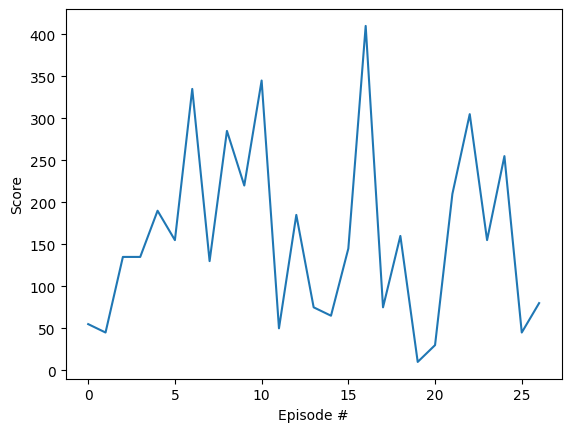

Episode 5	Average Score: 161.75

In [44]:
scores = train(100)

# run learnt agent

In [47]:
score = 0
state = stack_frames(None, obs, True)

while True:
    env.render()
    action, _, _ = agent.act(state)
    next_state, reward, done, truncated, info = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break
env.close()

You Final score is: 310.0
